Rahul Khanna

rahulkha@usc.edu

No team members

USC ID: 1599870732

Used Github to submit code

# Exploring BERT's Transfer Learning abilities in the hope of creating a more efficient TableBERT

Disclaimer: My initial idea was to explore an Active Learning approach to solve a claim entailment problem, this turned out to be quite an undertaking--mainly due to computational limitations. However, my main interest behind this approach was to optimize around efficiency, and so in this same vein I look at another efficiency optimization idea. I wanted to see if there was a real benefit to fine-tuning the whole Bert-Base-Multilingual-Cased model, or just the last classifier bit. If the performance is similar then it is much more efficient to just train the final classifier layer.

Ideas Explored: Freezing Layers, Transfer Learning

### Introduction

The dataset I choose to explore is the Tab-Fact Dataset, which was put together by some researchers at UCSB and the Tencent AI Lab in Seattle. The problem goes is as follows, given a statement and a table from a relational database, can one build a classifier to determine if the statement is true or false. The dataset that is provided gurantees that the facts needed to prove or disprove the statement lie within the given table.
The data for this task can be found here: https://tabfact.github.io/. I will be referencing the paper associated with this dataset, TabFact, and one of their solutions, TableBERT, throughout this report.

I am framing this problem as a binary classification problem, where given two inputs (the statement and the table) I must produce either a 1 - the statement is True, or a 0 - the statement is false. My goal will be to first replicate the TableBert results shown in the paper, and then slightly adapt TableBERT to allow for freezing of all BERT Layers. Once I have done this I will look at how well the frozen version of TableBERT does in comparison to the full TableBERT.

The ways I will compare the two:

    Accuracy over training points shown

    Accuracy over time

I am looking to explore if the frozen version of TableBERT is more efficient in either of these two categories. If so, one could argue using the frozen version of TableBert is a better idea, as it is the simpler version of the two and it achieves similar accuracy more efficiently than the full TableBERT. This in turn would show a strong amount of transfer learning is possible between the original Masked Language Modeling and Sequence Relationship task BERT is trained on and my current statement entailment task.

I also built out functionality for using RoBERTa, but due to time and computional constraints have not run experiments using that mode. 

I will also be using the provided Dev and Train splits by the TabFact paper, here is what the split looks like in terms of number of examples.

Data Split:
    
    Train: 90,232
    
    Dev:   12,791

One of the TabFact authors (Wenhu Chen at UCSB) has uploaded the [code](https://github.com/wenhuchen/Table-Fact-Checking) used for the experiments in TabFact, as well as a checked in version of the best preforming TableBERT experiment. I will be heavily relying on his code, which in turn relies on the [examples](https://github.com/huggingface/transformers/tree/master/examples) provided by The HuggingFace company.

### Baseline: TableBERT
BERT is primarily a transformer based Language Model, that can give contextualized embeddings for a word based on the words around it. This means that each word is not stuck with a single embedding, rather a word's embedding changes depending on its context. This fits nicely with the concept of word senses as many words have many senses, and forcing one single vector to capture all those senses is much more difficult than allowing for multiple vectors. BERT's contextualized embeddings have shown to be extremely powerful in many downstream tasks, including sequence pair classification (Q-A tasks, QQp task). 

TableBERT is an adaptation of the sequence pair classification task which BERT has been trained on. BERT's first training is done on the Language Modeling task, but it is also trained on the task of predicting if two sequences are neighbors in a larger body of text. The way BERT is used in this classification task is you append the two sequences together in the following way:

    [cls]sequence_a[sep]sequence_b[sep]

You then extract the hidden vector of the special CLS token of the last layer of BERT and train a classifier that takes in this hidden state and outputs your final predictions. For simplicity this final classifier is usually a single liner layer that projects the 768 dimension BERT embedding to a **c** dimensional space where an argmax is used to discern what the label should be. C is the number of classes you are labeling over. I would like to point out though that it can be whatever you'd like it to be. In the case of TableBERT it is standard single linear layer.

In the context of this statement entailment task, TableBERT treats sequence_a as the task and sequence_b as a strung together representation of the table. The order of fact vs table actually matters very little, so to stay consistent with their checked in model I will be following this ordering, even though according to their paper they claim table then statement works better. The stated difference in performance is 0.1%.

As the table is not a natural language sequence, the performance of this type of approach to the problem is heavily reliant on the methodology of converting the table into a sequence. The TabFact authors decided to follow a very basic template filling process where the table is broken down into one long string of decently coherent sentences describing each row. So if a table had **N** rows the sequence representing the table would look like:

    template_for_row_1.template_for_row_2....template_for_row_n.
    
    The template per table is fixed.

The paper tried other methods, but this horizontal scan of the table along with the template filling was the approach they found worked best. This makes sense as these tables are relational, so there is some sort of relation between the columns, therefore there should hypothetically exists some sort of template to string together the information in a row for any given table. Of course the approach taken isn't to fit an exact template to each table, but there are some simple rules it follows so that every table doesn't have to follow the same template. It is important when using BERT for classification purposes that you mimic as closely as possible the initial training task BERT was trained on (true for any type of transfer learning), so it is not a surprise this methodolgy worked better than their other efforts.

In training TableBERT, the authors opted to update all parameters of BERT during training, which is quite an expensive task. In fact their optimal results were found while only going through half the training points, so not even a whole epoch. They used a batch size of 6 (due to memory constraints) and a learning rate of 5*e^-5.

### How I went about the problem

In trying to replicate the paper's approach I noticed how expensive it was to train all the parameters of BERT. I was using a NVIDIA Tesla K80 GPU, and I initially ran into problems with batch sizes. The largest batch size I could use for replication purposes was 6, which I confirmed with the author was their default due to memory constraints. I feel that a batch size of 6 is increadibly small, and the gradient gained from just 6 training points out of the possible 90,232 training datapoints can't be a great representation of the overall gradient––meaning that the direction the weights are being updated in are probably often wrong.

When I finally got the training started, I quickly realized one epoch of training, with periodic evaluations, would require over 14 hours of training. I also then realized that the paper's best results were achieved without even an epoch's worth of training. Again I found this odd, as the model is not being shown all examples available, so I feel that there is something strange with this training process. In fact it actually hurts the model to see all the examples, you can see a graph on the TabFact github page that shows a sharp deterioation of performance as the first epoch comes to an end. 

I found the whole replication experience to be quite an inhibiting aspect of using BERT to help solve problems. If you have various downstream tasks that you'd like to use BERT for, to train multiple different BERT based models would take a lot of computation power as well as time. Now some of this time / required computational power has to be accepted as even in the evaluation step it takes roughly 15 minutes for a BERT based model to go through the 12K training points. However, as I was thinking about how I could speed up this training / replicatin process I realized that I could just use BERT as an encoder, instead of trying to update it's weights. There is no gurantee that this representation will be useful, but as I started reading online I quickly found that the concept of "freezing" layers while training large models existed. Freezing layers essentially amounts to allowing certain layers' weights to be updated using gradient descent in training, while stopping other layers' weights from being updated. From an engineering point of view, I could just freeze all of BERT's layers and then just update the final projection matrix to one that fit my entailment task. This would severly cut down the number of weights I had to train, from 110M + 768\*2 paramaters to just 728\*2 parameters, well over a 99% reduction in the number of parameters needing an update. 

This concept of just using BERT as an encoder is exactly why BERT became such a popular and groundbreaking model in the NLP community, the model allows for transfer learning in NLP. This is shown by the various serious improvements of using BERT as an encoder for other NLP tasks (i.e not the Masked Language Model task that it is primarily trained on). Hence I figured I'd explore what amount of transfer learning is possible in this statement entailment task.

It is also not unreseasonable to assume that information learned from the language model task as well as the sentence relationship task will not be helpful to a model in being able to discern whether a given statement is true or not based on facts. The statement verification task requires understanding (Language Modeling can help here), and some sort of relationship encoding between pieces of information (Sentence Relationship task can help here). However, I can also see downfalls to using BERT as an encoding layer as a claim might just be written really well and due to the heavy training of BERT on the Language Modeling task the model might think the statement is true––BERT might think its just evaluating if the statement looks gramatical or not, instead of true or not.

Regardless this idea fits really nicely with how BERT is used for classification tasks, as if I just assume that BERT does a good job of creating representation for a statement and table pair, then I can just learn a good projection matrix in order to classify the representation as being one that representents a statement that is true vs false. In the more classical ML concept, its like you have 768 features and you're trying to find the best hyperplane that divides the feature space. The problem of finding a hyperplane in a space is obviously much simpler, hence the huge reduction in the number of parameteres needing updating.

Also this might help the alleviate the problem of not being able to show TableBERT too many examples, i.e. the whole training corpus. The projection matrix can definitely improve as you go through more and more of the dataset, as long as you take into account overfitting. I try to take into account overfitting of the linear layer by using a dropout layer between BERT's output layer extraction and the final linear layer. The dropout perectange I used was 20%.

I ran two experiments to see how well transfer learning would work in this statement entailment task:

    1. Frozen TableBert, Batch Size 128 (largest I could do on my VM), Learning rate 5*e^-5
    2. Frozen TableBert, Batch Size 64, Learning rate 2*e^-5

I used a smaller learning rate in the second experiment as I reduced the batch size. I've read that its a good rule of thumb to do this, and I also think it makes sense as your gradient is more reliant the more points you use. I've also read that using too many points for SGD is a bad idea, but I don't think that applies in my case––I believe 128 is still considered a small batch size.

### Data and Analysis

In [20]:
import pandas as pd
import pygal
from IPython.display import SVG, display
replication_results = pd.read_csv("TableBERT_Results.csv")
checked_in_code_replication_results = pd.read_csv("Best_TableBERT_Results.csv")
frozen_bert_128 = pd.read_csv("FrozenBert128_Results.csv")
frozen_bert_64 = pd.read_csv("FrozenBert64_Results.csv")
joint_time_performance = pd.read_csv("Joint_Time_Performance.csv")

### TableBERT Replication Results

In [12]:
checked_in_code_replication_results

,Dataset,Accuracy,F1,Loss
0,Dev,0.6487,0.6867,0.5943
1,Simple_Test,0.7719,0.7862,0.4634
2,Complex_Test,0.5754,0.6286,0.6645
3,Test,0.6395,0.6776,0.5994
4,Small Test,0.6574,0.6870,0.5772


These result come from simply running the checked in model supplied by Wenhu Chen, and validating that they are indeed close to the results published in the TabFact paper. These results are in line with the [paper](https://arxiv.org/pdf/1909.02164.pdf)'s results, which can be found on page 7. Further I contacted Wenhu, and the results published in the paper are an average, so the slight deviation is acceptable.

In [2]:
replication_results

,Minutes Taken,Number of Steps,Number of Training Points,Dev Accuracy,Dev F1,Dev Loss
0,30,500,3000,0.5050,0.6203,0.6956
1,60,1000,6000,0.5072,0.6681,0.6887
2,90,1500,9000,0.5737,0.4070,0.6730
3,120,2000,12000,0.6089,0.5881,0.6619
4,150,2500,15000,0.6180,0.5737,0.6454
5,180,3000,18000,0.6077,0.6118,0.6683
6,210,3500,21000,0.6146,0.6321,0.6790
7,240,4000,24000,0.6364,0.6368,0.6362
8,270,4500,27000,0.6188,0.6882,0.6374
9,300,5000,30000,0.6450,0.6691,0.5969


These results come from me actually trying to train TableBERT from scratch to make sure I could fully replicate the TabFact paper's TableBERT results. If you look at the reported TableBERT's performance in this [chart](https://github.com/wenhuchen/Table-Fact-Checking/blob/master/resource/trend.jpg) you can see it roughly mimics my results. The performance of my TableBERT experiments plateau at around 0.64 for the dev accuracy, and it does so around 5-6K step mark. The below graph should show this more clearly.

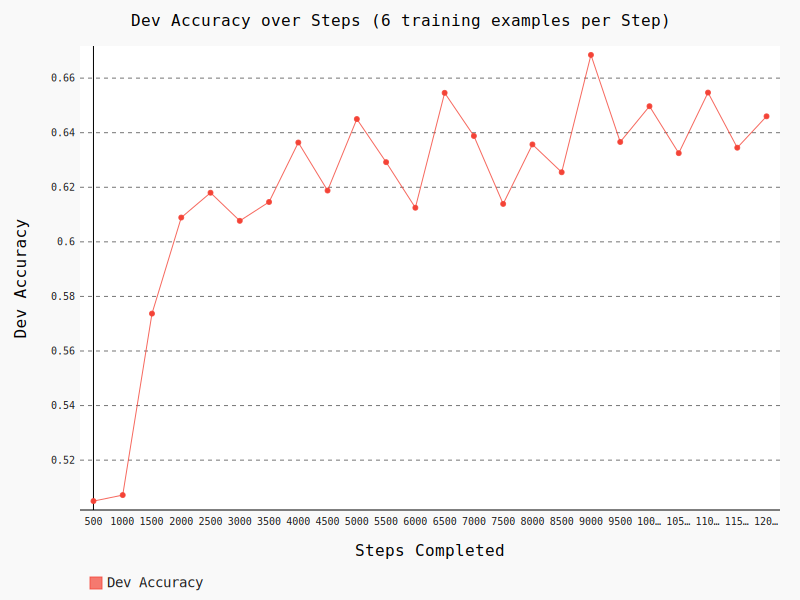

In [31]:
line_chart = pygal.Line(legend_at_bottom=True)
line_chart.title = 'Dev Accuracy over Steps (6 training examples per Step)'
line_chart.x_title = "Steps Completed"
line_chart.y_title = "Dev Accuracy"
line_chart.x_labels = list(replication_results["Number of Steps"])
line_chart.add("Dev Accuracy", list(replication_results["Dev Accuracy"]))
display(SVG(line_chart.render(disable_xml_declaration=True)))

### Frozen TableBert Results

**Experiment 1 -- Batch Size of 128**

In [17]:
frozen_bert_128

,Minutes Taken,Steps Taken,Number of Training Points,Dev Accuracy,Dev F1,Dev Loss
0,30,100,12800,0.5022,0.5120,0.7065
1,60,200,25600,0.5062,0.6574,0.7614
2,90,300,38400,0.5008,0.3677,0.7136
3,120,400,51200,0.5060,0.6466,0.7260
4,150,500,64000,0.5072,0.6604,0.7488
5,180,600,76800,0.5062,0.6721,0.8663
6,210,700,89600,0.5063,0.6723,1.0539
7,240,800,102400,0.5066,0.6556,0.7461
8,270,900,115200,0.4988,0.4808,0.7130


**Experiment 2 -- Batch Size of 64**

In [19]:
frozen_bert_64

,Minutes Taken,Number of Steps,Number of Training Points,Dev Accuracy,Dev F1,Dev Loss
0,40,300,19200,0.4948,0.1246,0.7455
1,80,600,38400,0.5059,0.6507,0.7189
2,120,900,57600,0.5066,0.6673,0.7596
3,160,1200,76800,0.5097,0.6389,0.7210
4,200,1500,96000,0.5056,0.6366,0.7159
5,240,1800,115200,0.5023,0.5745,0.7086
6,280,2100,134400,0.5066,0.6714,0.8470


So as we can see, even after over 4 hours of traning, there is no real change in performance of the overall classifier in either experiment. This highly indicates that in order to take advantage of the transfer learning offered by the BERT model we must update all the weights as done in the original TableBert implementation. It could also be that the final classifier used at the end was too simple, i.e. there was no good hyper plane that could split the space of embeddings being produced by BERT.

### Joint Analysis

From the above graphs and tables, it is obvious that the frozen version of TableBERT can certainly not be considered a replacement for TableBERT. This means that in this current setup, in order to take advantage of the transfer learning offered by BERT, without updating the full model, we must update our classification piece to something more complex, maybe a multi-layer perceptron, for any chance of creating a more efficient version of TableBERT. There is no gurantee this will help though.

It is likely that a more resource efficient solution to this problem exists, but either not using BERT or changing the way the table is encoded into a sequence. These results show that in order to take advantage of a BERT based model using a simple `table_to_sequence` method you must train at least some of the weights in the the BERT model, and not just the final simple project layer.

I think from the above tables its clear that from a **number of training points shown perspective, the original TableBERT is more efficient than the versions of the frozen TableBERT**. However, because the two experiments don't have as many parameters to tune, we can process more datapoints per second, so to makes sure from a time perspective the two experiments are not more efficient than TableBERT you can look at the below graph. **In both forms of efficiency regular TableBERT is more efficient.**

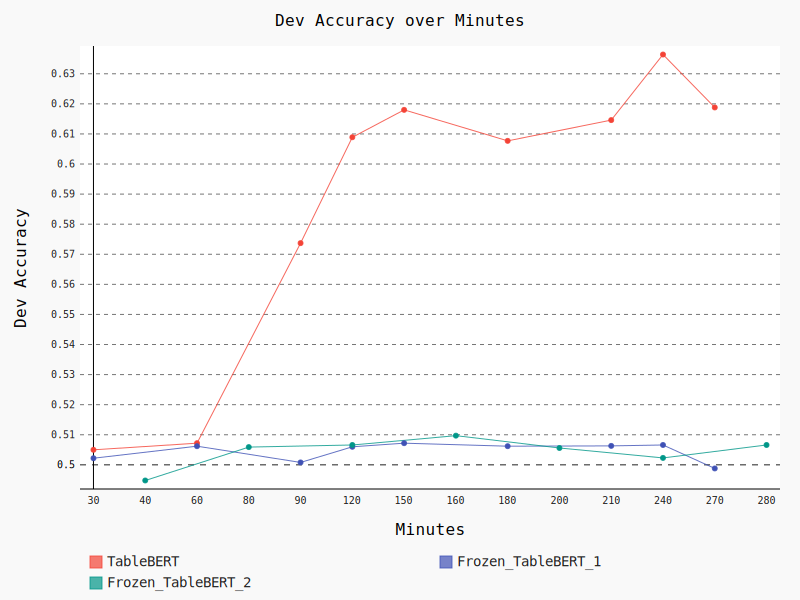

In [30]:
line_cart_2 = pygal.Line(legend_at_bottom=True)
line_cart_2.title = 'Dev Accuracy over Minutes'
line_cart_2.x_labels = list(joint_time_performance["Minutes Taken"])
line_cart_2.x_title = "Minutes"
line_cart_2.y_title = "Dev Accuracy"
line_cart_2.add("TableBERT", [x if not pd.isna(x) else None for x in joint_time_performance["TableBERT"]])
line_cart_2.add("Frozen_TableBERT_1", [x if not pd.isna(x) else None for x in joint_time_performance["Frozen_TableBERT_1"]])
line_cart_2.add("Frozen_TableBERT_2", [x if not pd.isna(x) else None for x in joint_time_performance["Frozen_TableBERT_2"]])
display(SVG(line_cart_2.render(disable_xml_declaration=True)))


### Qualitative Analysis

A bit hard to look into this as the two experiments are not showing performance any better than random, so instead here are some of the examples that regular TableBERT gets right vs wrong. After going through them, there is no real trend that I can find (which is also mentioned) in the paper, as sometimes TableBERT gets really easy things wrong  and some hard things right. However, in general the simpler the statement is to verify (i.e. using only one row of information) the easier it is for TableBERT to do a good job. 

Note: Statements have been lemmatized and parsed for UNK words

**Examples from TableBERT:**

**Simpler Claims:**

*Table:* [Second table found here](https://en.wikipedia.org/wiki/Australia_and_the_United_Nations)

*Examples gotten Correct:*

Claim: australia 's role as military advisor be in the un operation unam (True)

Claim: 65 australian be involve in the un in 1992 - 1993 (False)

*Examples gotten Wrong:*

Claim: australia 's role in the un operation un consular commission be as military advisor (False)

Claim: 65 australian be involve in the un advance mission in cambodia from 1991 - 199 (True)

**More Complex Claims:**

*Table:* [1st table found here](https://en.wikipedia.org/wiki/2000_United_States_presidential_election_in_Nevada)

*Examples gotten Correct:*

Claim: clark county have the narrowest margin between gore and bush during the \[UNK\] (True)

Claim: during the \[UNK\] gore win only 1 county \[UNK\] lincoln county with 51.3% of the vote (False)

*Examples gotten Wrong:*

Claim: pershing county have the narrowest margin between gore and bush during the \[UNK\] (False)

Claim: for the state of \[UNK\] the independent candidate during the \[UNK\] receive the most vote in humboldt county (False)

### Conclusion

In conclusion if one is trying to build a more efficient version of TableBERT, one must take one of the following options, as simply using BERT as an encoder and then adding a linear classifier at the end is not enough to take advantage of the possability of BERT's transfer learning in this statement entailment task:

1. Use a more complex classifier on top of BERT's encodings
2. Train some of the layers of BERT, i.e. don't freeze all of them
3. Change the methodology of converting a table into a sequence

The two experiments I ran were neither more efficient in terms of number of labels or time.